# Pytroch autodiff example

In [6]:
import torch

x = torch.tensor(5.0, requires_grad=True)
f = 2 * (x ** 2) + 5
f.backward()
print(x.grad)  # This will print the derivative of f with respect to x


tensor(20.)


# Units lookups
kcal/(g * Å) in Å/(ps²) wolfram says: <br>

418.4 Å/ps^2 (ångströms per picosecond squared) <br>

maybe I should have used a unit package but I havent used one before


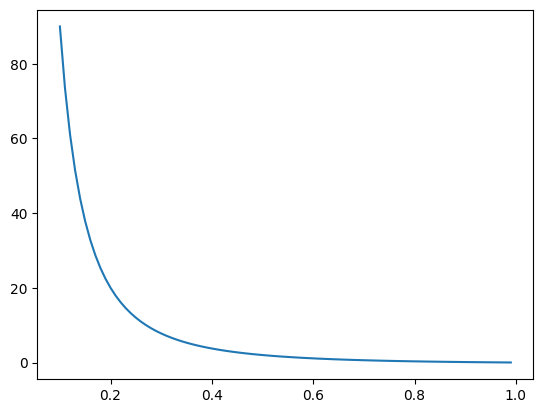

In [158]:
import matplotlib.pyplot as plt
import numpy as np

xx = np.arange(0.1, 1,0.01)  
yy = 1/(xx**2)-1/xx 

plt.plot(xx, yy)
plt.show()


# Reflection image
![reflection img](reflection_img.jpg)

In [304]:
from dataclasses import dataclass
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange

@dataclass
class Simulation_constants:
    """Holds simulation constants"""
    m: float = 39.9748 # g/mol , mass
    T: float = 300 # K , T
    sigma: float = 3.4 # A, particle size
    eps: float = 0.24 # kcal/mol interactions_strength
    # A box defined by 2 corners (xi,yi), (xf,yf)
    xi: float = 0 # A
    yi: float = 0 # A
    xf: float = 20 # A
    yf: float = 20 # A


class MD_simulation(ABC):
    def __init__(self,sim_cons,pos_file="intial_pos.csv",vel_file="intial_vel.csv",debug=False):
        self.positions = torch.from_numpy(np.genfromtxt(pos_file)) # A
        self.velocities  = torch.from_numpy(np.genfromtxt(vel_file)) # A/ps
        self.accelerations = torch.zeros_like(self.positions) # A/ps^2 has to be defined
        self.positions.requires_grad = True
        self.constants = sim_cons
        self.total_steps = 0  
        self.debug = debug

        if self.positions.shape != self.velocities.shape:
            raise ValueError("Positions and velocities must have the same shape")
    

    def get_distances_squared(self):   
        """Calculates the distance matrix squared."""
        # broadcasting points (p) to get z_i - z_j for each coordinate (c), redundant x_j-x_i 
        diff = rearrange(self.positions, 'p c -> p 1 c') - rearrange(self.positions, 'p c -> 1 p c') # A
        return torch.einsum('ijc,ijc->ij', diff, diff) # A^2

    @abstractmethod   
    def get_potential_energy(self):
        """Calculates the potential energy."""
        pass

    def get_force(self):
        """Calculates the force as the negative gradient of the potential energy."""
        forces, = torch.autograd.grad(self.get_potential_energy(), self.positions, create_graph=True)
        return -forces #kcal/(mol * A)

    @abstractmethod   
    def step(self):
        """Performs a single step of the simulation."""
        pass


    def step_reflect(self):
        """Reflects particles that have crossed the boundary."""

        # see img, calculating difference between point and corners with broadcasting
        diff_to_axis = rearrange(self.positions, "p c -> 1 p c") - torch.tensor([
            [[self.constants.xi, self.constants.yi]],
            [[self.constants.xf, self.constants.yf]]
        ])

        # figures out that the point is at right side of the corner
        diff_to_axis[1, :, :] *= -1
        diff_to_axis = torch.min(diff_to_axis, torch.tensor([0]))
        diff_to_axis[0, :, :] *= -1

        # the adjustment is diff *2 and are exclusive so can be combined
        pos_adj = 2 * torch.einsum("h p c -> p c", diff_to_axis)

        # where an adjustment happens the velocity gets multiplied by -1
        vel_adj = torch.where(torch.abs(pos_adj) > 0, -1, 1)

        if self.debug:
            print("Debug Information: Reflect Step")
            print("-" * 40)  # Separator for better readability
            print("Current Boundary Corners:")
            print(f"Bottom Left Corner: ({self.constants.xi}, {self.constants.yi})")
            print(f"Top Right Corner: ({self.constants.xf}, {self.constants.yf})")
            print("\nPosition Adjustments (pos_adj):")
            print(pos_adj)
            print("\nVelocity Adjustments (vel_adj):")
            print(vel_adj)
            print("-" * 40)  # Separator for clarity
            self.plt_points()

        # update positions and velocities
        self.positions = self.positions + pos_adj
        self.velocities = self.velocities * vel_adj

        if self.debug:
            self.plt_points()


    def plt_points(self):
        """Try it to see what is does."""
        pos = self.positions.detach().numpy()  # Positions
        vel = self.velocities.detach().numpy()  # Velocities
        acc = self.accelerations.detach().numpy()  # Accelerations

        plt.scatter(pos[:, 0], pos[:, 1], color='blue', label='Particles')  # Scatter plot for the points

        # Annotate each point with an identifier (e.g., index)
        for i, (x, y) in enumerate(pos):
            plt.annotate(f'{i}', (x, y), textcoords="offset points", xytext=(5, 5), ha='center')

            # Add arrows for velocities
            plt.arrow(x, y, vel[i, 0], vel[i, 1],
                    head_width=0.1, head_length=0.2,
                    fc='red', ec='red',
                    length_includes_head=True)  # Draw velocity vectors as arrows

            # Add arrows for accelerations
            plt.arrow(x, y, acc[i, 0], acc[i, 1],
                    head_width=0.1, head_length=0.2,
                    fc='green', ec='green',
                    length_includes_head=True)  # Draw acceleration vectors as arrows

        # Draw the box
        box_x = [self.constants.xi, self.constants.xf, self.constants.xf, self.constants.xi, self.constants.xi]
        box_y = [self.constants.yi, self.constants.yi, self.constants.yf, self.constants.yf, self.constants.yi]
        plt.plot(box_x, box_y, color='black', linestyle='--', label='Box')  # Draw the box

        # Labels and limits
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        plt.xlim(-5, 25)
        plt.ylim(-5, 25)
        plt.grid(True)
        plt.legend()  # Add legend to distinguish the particles and boundary box
        plt.title('Particle Positions with Velocities and Accelerations')
        plt.show()




class MD_simulation_lj_vv(MD_simulation):
    """Implements the Lennard-Jones potential and Velocity Verlet integration step"""

    def __init__(self,sim_cons,pos_file="initial_pos.csv",vel_file="initial_vel.csv",debug=False):
        MD_simulation.__init__(self,sim_cons,pos_file,vel_file,debug)
        self.accelerations = self.get_acceleration()


    def get_potential_energy(self):
        """Calculates Lennard-Jones potential"""
        tmp = self.get_distances_squared() + 1e-9 # added eps, avoid dividing by 0, A^2
        tmp = self.constants.sigma**6/tmp**3 # A^6/A^6 
        tmp = 4*self.constants.eps*tmp*(1-tmp) # kcal/mol
        return torch.einsum("ij->", torch.triu(tmp, diagonal=1)) # kcal/mol
    
    def get_acceleration(self):
        """F = ma and unit stuff."""
        a = self.get_force()/self.constants.m #kcal/(mol * A * (g/mol)) = kcal/(g *A) = 418.4 A/(ps^2)
        a_unit_factor_kcal_per_gA_to_A_per_ps2 = 418.4
        a *= a_unit_factor_kcal_per_gA_to_A_per_ps2
        return a


    def step(self,dt):
        """Implements Velocity Verlet integration step combined with reflection."""
        #order matters
        self.positions = self.positions + self.velocities*dt + 0.5*self.accelerations*dt**2
        self.step_reflect()
        new_a = self.get_acceleration() 
        self.velocities = self.velocities + 0.5*(self.accelerations+new_a)*dt
        self.accelerations = new_a
        self.total_steps +=1




# Testing reflection

Debug Information: Reflect Step
----------------------------------------
Current Boundary Corners:
Bottom Left Corner: (0, 0)
Top Right Corner: (20, 20)

Position Adjustments (pos_adj):
tensor([[-6.4731, -7.6373],
        [ 6.7300,  7.3220],
        [-6.1101,  0.0000],
        [-6.4720,  7.1241],
        [ 6.7300, -7.4380],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  5.1648],
        [ 0.0000, -7.4761]], dtype=torch.float64, grad_fn=<MulBackward0>)

Velocity Adjustments (vel_adj):
tensor([[-1, -1],
        [-1, -1],
        [-1,  1],
        [-1, -1],
        [-1, -1],
        [ 1,  1],
        [ 1,  1],
        [ 1,  1],
        [ 1,  1],
        [ 1, -1],
        [ 1, -1]])
----------------------------------------


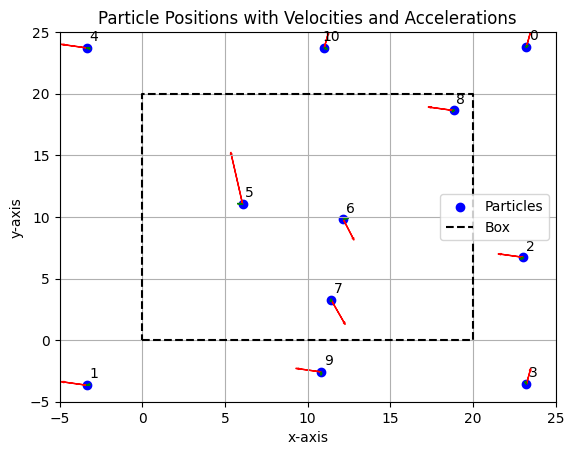

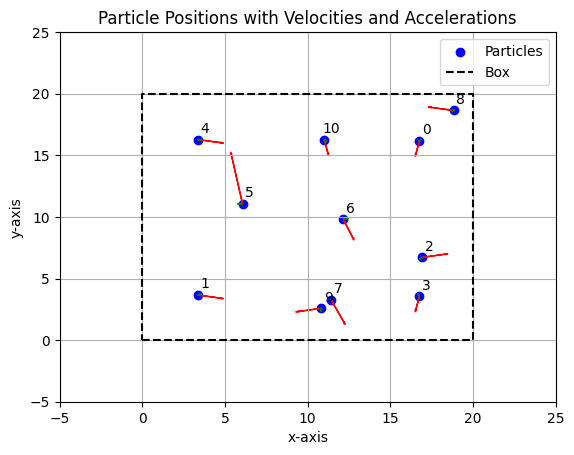

In [301]:
sim_cons = Simulation_constants()
sim = MD_simulation_lj_vv(
    sim_cons=sim_cons,
    pos_file="./test_init/reflect_pos.csv",
    vel_file="./test_init/reflect_vel.csv",
    debug=True
    )
sim.step(dt=0.1)

# Testing Force, Potential, Distances

In [298]:
import pandas as pd
sim_cons = Simulation_constants()
sim = MD_simulation_lj_vv(sim_cons)
np.set_printoptions(precision=0)
print("potential:",sim.get_potential_energy().detach().numpy())
print("force:",pd.DataFrame(sim.get_force().detach().numpy()))
print("distances: \n",pd.DataFrame(sim.get_distances_squared().detach().numpy()))

potential: 2.527774287500859
force:            0         1
0   0.004474 -0.118351
1   0.075309  0.073910
2  -0.088889  0.052455
3  -0.003139 -0.165185
4   0.018319  0.076752
5   0.089570 -0.087697
6   0.011595 -0.048770
7  -0.014621  0.261932
8  -0.091550 -0.048004
9  -0.126764 -0.069409
10  0.061445 -0.070183
11 -0.068784  0.099091
12  0.121284 -0.104499
13  0.026355  0.067866
14  0.113338  0.040729
15 -0.127942  0.039365
distances: 
           0         1         2         3         4         5         6   \
0     0.0000  142.6793  311.1941  188.3492  161.0513   48.2128   57.6385   
1   142.6793    0.0000  306.7810  426.4605  228.8656  122.1217  287.4394   
2   311.1941  306.7810    0.0000  114.6301   27.0650  115.0453  193.5848   
3   188.3492  426.4605  114.6301    0.0000   51.5077   93.6340   41.9953   
4   161.0513  228.8656   27.0650   51.5077    0.0000   35.8121   77.7730   
5    48.2128  122.1217  115.0453   93.6340   35.8121    0.0000   42.6977   
6    57.6385  287.4394  193.

# Testing lj_vv simulation

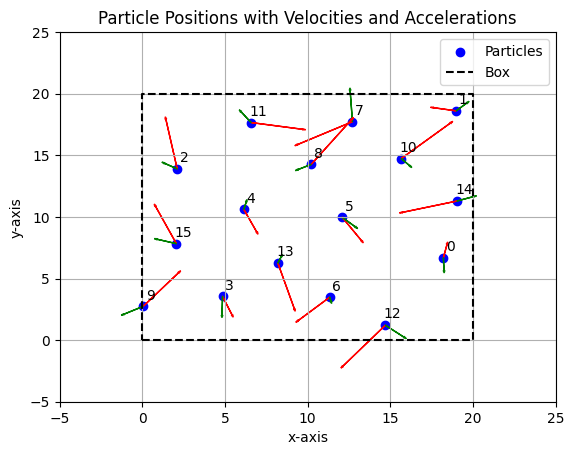

1


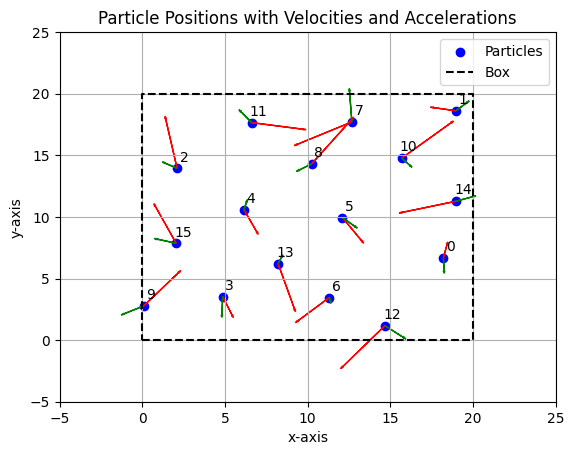

11


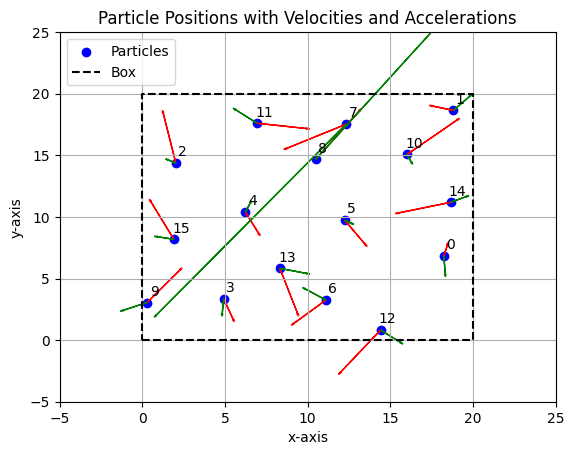

21


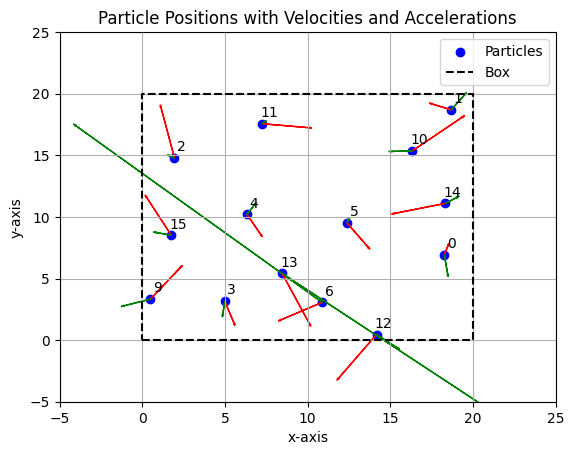

31


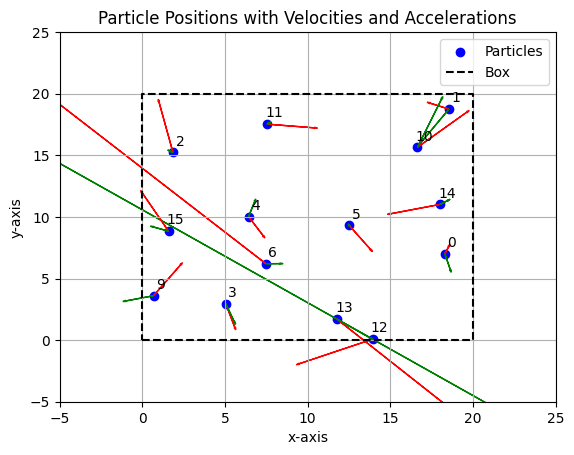

41


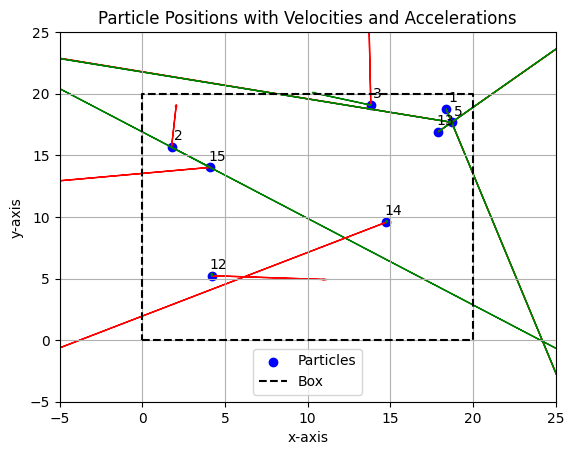

51


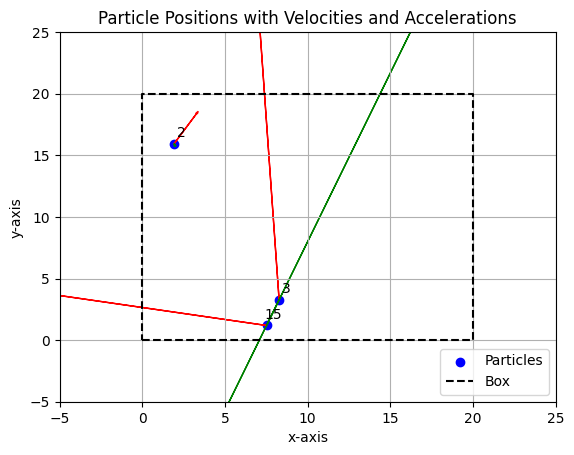

61


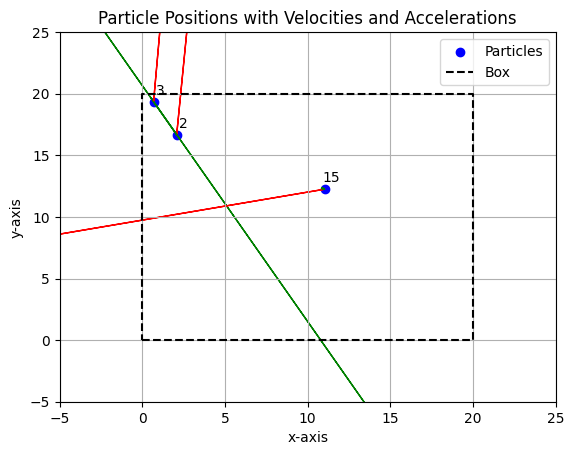

71


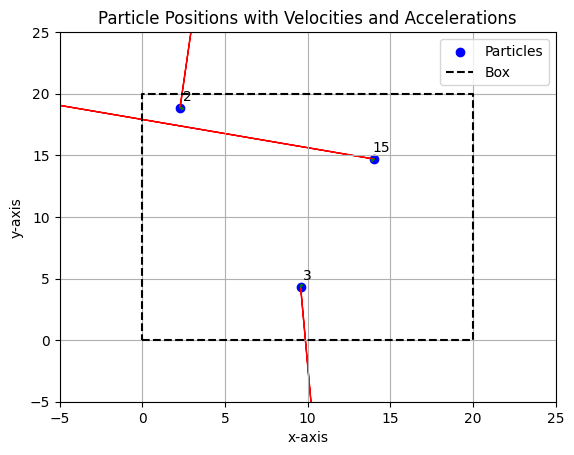

81


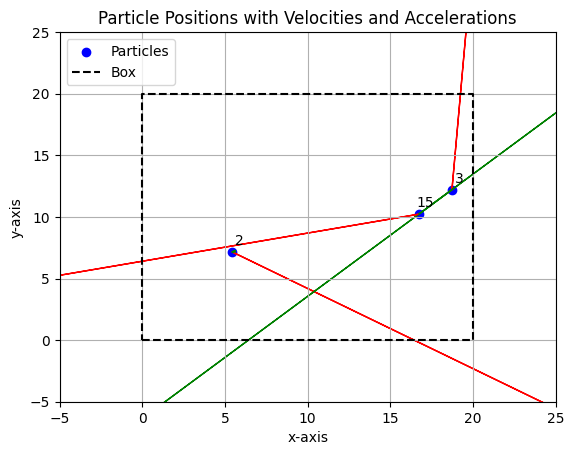

91


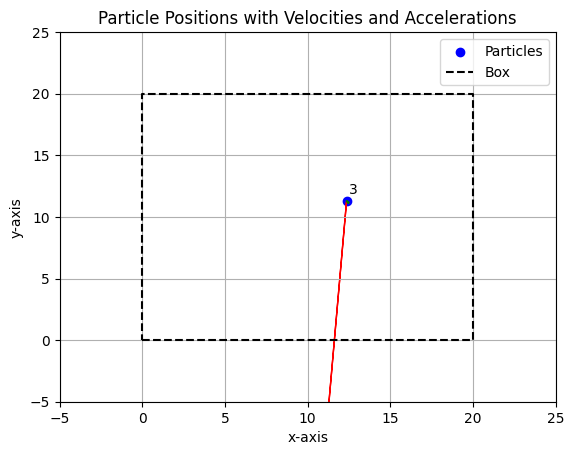

In [306]:
sim_cons = Simulation_constants()
sim = MD_simulation_lj_vv(sim_cons)

sim.plt_points()
for i in range(100):
    sim.step(dt=0.01)
    if i%10 == 0:
        print(sim.total_steps)
        sim.plt_points()